In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt


In [2]:
df = pd.read_csv('../data/zillow_data.csv')
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [3]:
df.groupby('RegionID')['State'].count()

RegionID
58196     1
58197     1
58200     1
58201     1
58202     1
         ..
677175    1
698721    1
738092    1
753843    1
753844    1
Name: State, Length: 14723, dtype: int64

In [4]:
df_first_5 = df.head().copy()

In [5]:
df_first_5

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [6]:
df_time_series = pd.DataFrame(index=pd.to_datetime(df.columns[7:]), data=np.ones(len(df.columns)-7))
for i in range(df.shape[0]):
    df_time_series[df['RegionID'][i]] = df.iloc[i,7:]
df_time_series.drop(df_time_series.columns[0],axis=1, inplace=True)
df_time_series

,84654,90668,91982,84616,93144,91733,61807,84640,91940,97564,...,59187,94711,62556,99032,62697,58333,59107,75672,93733,95851
1996-04-01,334200,235700,210400,498100,77300,95000,152900,216500,95400,766000,...,80800,135900,78300,136200,62500,94600,92700,57100,191100,176400
1996-05-01,335400,236900,212200,500900,77300,95200,152700,216700,95600,771100,...,80100,136300,78300,136600,62600,94300,92500,57300,192400,176300
1996-06-01,336500,236700,212200,503100,77300,95400,152600,216900,95800,776500,...,79400,136600,78200,136800,62700,94000,92400,57500,193700,176100
1996-07-01,337600,235400,210700,504600,77300,95700,152400,217000,96100,781900,...,78600,136900,78200,136800,62700,93700,92200,57700,195000,176000
1996-08-01,338500,233300,208300,505500,77400,95900,152300,217100,96400,787300,...,77900,137100,78100,136700,62700,93400,92100,58000,196300,175900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-01,1018700,316600,321200,1299000,120300,162800,414300,777900,172300,3778700,...,123400,257600,171300,341000,122800,216400,213100,130600,694700,348900
2018-01-01,1024400,318100,321200,1302700,120300,162800,413900,778500,173300,3770800,...,124400,258000,172400,342300,123200,213100,213700,131700,706400,350400
2018-02-01,1030700,319600,323000,1306400,120500,162900,411400,780500,174200,3763100,...,125500,260600,173600,345000,123200,209800,218300,132500,705300,353000
2018-03-01,1033800,321100,326900,1308500,121000,163500,413200,782800,175400,3779800,...,126600,264700,175800,348000,120700,209200,222700,133000,681500,356000


In [7]:
df_time_series

,84654,90668,91982,84616,93144,91733,61807,84640,91940,97564,...,59187,94711,62556,99032,62697,58333,59107,75672,93733,95851
1996-04-01,334200,235700,210400,498100,77300,95000,152900,216500,95400,766000,...,80800,135900,78300,136200,62500,94600,92700,57100,191100,176400
1996-05-01,335400,236900,212200,500900,77300,95200,152700,216700,95600,771100,...,80100,136300,78300,136600,62600,94300,92500,57300,192400,176300
1996-06-01,336500,236700,212200,503100,77300,95400,152600,216900,95800,776500,...,79400,136600,78200,136800,62700,94000,92400,57500,193700,176100
1996-07-01,337600,235400,210700,504600,77300,95700,152400,217000,96100,781900,...,78600,136900,78200,136800,62700,93700,92200,57700,195000,176000
1996-08-01,338500,233300,208300,505500,77400,95900,152300,217100,96400,787300,...,77900,137100,78100,136700,62700,93400,92100,58000,196300,175900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-01,1018700,316600,321200,1299000,120300,162800,414300,777900,172300,3778700,...,123400,257600,171300,341000,122800,216400,213100,130600,694700,348900
2018-01-01,1024400,318100,321200,1302700,120300,162800,413900,778500,173300,3770800,...,124400,258000,172400,342300,123200,213100,213700,131700,706400,350400
2018-02-01,1030700,319600,323000,1306400,120500,162900,411400,780500,174200,3763100,...,125500,260600,173600,345000,123200,209800,218300,132500,705300,353000
2018-03-01,1033800,321100,326900,1308500,121000,163500,413200,782800,175400,3779800,...,126600,264700,175800,348000,120700,209200,222700,133000,681500,356000


In [8]:
df_time_series.drop(df_time_series.columns[0],axis=1, inplace=True)

In [9]:
df_time_series

,90668,91982,84616,93144,91733,61807,84640,91940,97564,62037,...,59187,94711,62556,99032,62697,58333,59107,75672,93733,95851
1996-04-01,235700,210400,498100,77300,95000,152900,216500,95400,766000,162000,...,80800,135900,78300,136200,62500,94600,92700,57100,191100,176400
1996-05-01,236900,212200,500900,77300,95200,152700,216700,95600,771100,162300,...,80100,136300,78300,136600,62600,94300,92500,57300,192400,176300
1996-06-01,236700,212200,503100,77300,95400,152600,216900,95800,776500,162600,...,79400,136600,78200,136800,62700,94000,92400,57500,193700,176100
1996-07-01,235400,210700,504600,77300,95700,152400,217000,96100,781900,163000,...,78600,136900,78200,136800,62700,93700,92200,57700,195000,176000
1996-08-01,233300,208300,505500,77400,95900,152300,217100,96400,787300,163400,...,77900,137100,78100,136700,62700,93400,92100,58000,196300,175900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-01,316600,321200,1299000,120300,162800,414300,777900,172300,3778700,887800,...,123400,257600,171300,341000,122800,216400,213100,130600,694700,348900
2018-01-01,318100,321200,1302700,120300,162800,413900,778500,173300,3770800,890500,...,124400,258000,172400,342300,123200,213100,213700,131700,706400,350400
2018-02-01,319600,323000,1306400,120500,162900,411400,780500,174200,3763100,901700,...,125500,260600,173600,345000,123200,209800,218300,132500,705300,353000
2018-03-01,321100,326900,1308500,121000,163500,413200,782800,175400,3779800,930700,...,126600,264700,175800,348000,120700,209200,222700,133000,681500,356000


In [10]:
df_time_series.resample('M').last()

,90668,91982,84616,93144,91733,61807,84640,91940,97564,62037,...,59187,94711,62556,99032,62697,58333,59107,75672,93733,95851
1996-04-30,235700.0,210400.0,498100.0,77300.0,95000.0,152900.0,216500.0,95400.0,766000.0,162000.0,...,80800.0,135900.0,78300.0,136200.0,62500.0,94600.0,92700.0,57100.0,191100.0,176400.0
1996-05-31,236900.0,212200.0,500900.0,77300.0,95200.0,152700.0,216700.0,95600.0,771100.0,162300.0,...,80100.0,136300.0,78300.0,136600.0,62600.0,94300.0,92500.0,57300.0,192400.0,176300.0
1996-06-30,236700.0,212200.0,503100.0,77300.0,95400.0,152600.0,216900.0,95800.0,776500.0,162600.0,...,79400.0,136600.0,78200.0,136800.0,62700.0,94000.0,92400.0,57500.0,193700.0,176100.0
1996-07-31,235400.0,210700.0,504600.0,77300.0,95700.0,152400.0,217000.0,96100.0,781900.0,163000.0,...,78600.0,136900.0,78200.0,136800.0,62700.0,93700.0,92200.0,57700.0,195000.0,176000.0
1996-08-31,233300.0,208300.0,505500.0,77400.0,95900.0,152300.0,217100.0,96400.0,787300.0,163400.0,...,77900.0,137100.0,78100.0,136700.0,62700.0,93400.0,92100.0,58000.0,196300.0,175900.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-31,316600.0,321200.0,1299000.0,120300.0,162800.0,414300.0,777900.0,172300.0,3778700.0,887800.0,...,123400.0,257600.0,171300.0,341000.0,122800.0,216400.0,213100.0,130600.0,694700.0,348900.0
2018-01-31,318100.0,321200.0,1302700.0,120300.0,162800.0,413900.0,778500.0,173300.0,3770800.0,890500.0,...,124400.0,258000.0,172400.0,342300.0,123200.0,213100.0,213700.0,131700.0,706400.0,350400.0
2018-02-28,319600.0,323000.0,1306400.0,120500.0,162900.0,411400.0,780500.0,174200.0,3763100.0,901700.0,...,125500.0,260600.0,173600.0,345000.0,123200.0,209800.0,218300.0,132500.0,705300.0,353000.0
2018-03-31,321100.0,326900.0,1308500.0,121000.0,163500.0,413200.0,782800.0,175400.0,3779800.0,930700.0,...,126600.0,264700.0,175800.0,348000.0,120700.0,209200.0,222700.0,133000.0,681500.0,356000.0


<AxesSubplot:>

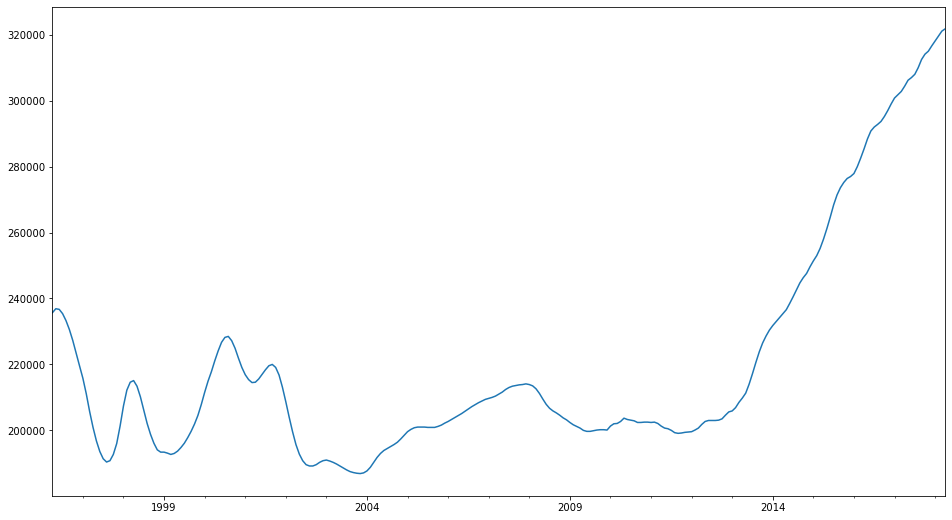

In [11]:
df_time_series.iloc[:,0].plot(figsize=(16,9))

In [12]:
roll_mean = df_time_series[84654].rolling(window=12).mean()
data_minus_roll_mean = df_time_series[84654] - roll_mean

KeyError: 84654

<AxesSubplot:>

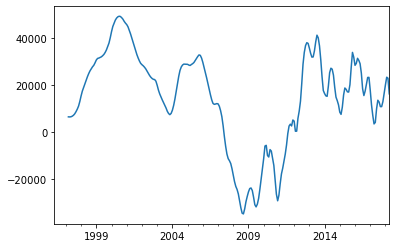

In [ ]:
data_minus_roll_mean.plot()

In [ ]:
df.groupby('RegionID')['RegionName'].count()

RegionID
58196     1
58197     1
58200     1
58201     1
58202     1
         ..
677175    1
698721    1
738092    1
753843    1
753844    1
Name: RegionName, Length: 14723, dtype: int64

use p value from df test on skylar chart

In [ ]:
df['CountyName'].value_counts().head(20)

Los Angeles    264
Jefferson      175
Orange         166
Washington     164
Montgomery     159
Cook           140
Harris         127
Jackson        118
Middlesex      117
Maricopa       111
Franklin       110
Suffolk        110
Clark           94
Marion          92
Monroe          90
San Diego       87
Madison         85
Douglas         83
Lake            79
Dallas          77
Name: CountyName, dtype: int64